In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun Jul  4 03:18:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !pip install gputil
# !pip install psutil
# !pip install humanize

In [4]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# def printm():
#   GPUs = GPU.getGPUs()
#   gpu = GPUs
#   process = psutil.Process(os.getpid())
#   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [5]:
!cp /content/drive/MyDrive/Viettel2/train_n.csv /content
!cp /content/drive/MyDrive/Viettel2/test_n.csv /content

In [6]:
import torch 
from torch import nn 
import pandas as pd 
import numpy as np 
from torch.utils.data import Dataset,DataLoader,random_split
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence 
from torch import optim 
from sklearn.metrics import accuracy_score,classification_report
import time 
import pickle
import random
from torch.nn import functional as F

In [7]:
train=pd.read_csv('train_n.csv')
test=pd.read_csv('test_n.csv')

In [8]:
train

,file_name,text,label
0,VH_VNE_ (2441).txt,Khoả_thân cảnh_tỉnh bệnh AIDS Ca_sĩ Dannii_Min...,0
1,VH_NLD_ (4206).txt,Triển_lãm áo_dài đất Mỹ_Nữ_sinh Châu_Đốc áo_dà...,0
2,VH_NLD_ (3718).txt,Harrison_Ford đàn_ông đa_tình Vào_vai Jack Sta...,0
3,VH_TT_ (3159).txt,Tiếng hát sông Hàn tình_ca gia_đình Sinh đất_n...,0
4,VH_TN_ (3567).txt,Triển_lãm tranh họa Mark_Jones diễn gallery Tự...,0
...,...,...,...
33754,DS_TN_ (4630).txt,cô_đơn chẳng trống_rỗng rơi tham_khảo khuyên g...,9
33755,DS_ VNE_ (3077).txt,Quang bình_tĩnh nóng_vội một_chiều sống cuộc_đ...,9
33756,DS_TN_ (4913).txt,tuấn_mã châu đạp chân trường_đua Phú_Thọ thay ...,9
33757,DS_ VNE_ (1028).txt,Bánh_cuốn làng Kênh Bánh_cuốn làng Kênh Nam_Đị...,9


In [ ]:
n_samples=len(train)
weights=[]
for i in range(10):
    weights.append(len(train[train.label==i]))
weights=[np.log10(n_samples/value) for value in weights]
weight=torch.tensor(weights,dtype=torch.float)

In [ ]:
random.seed(42)
val=train[train.label==0].sample(int(len(train[train.label==0])*0.25))
for i in range(1,10,1):
  temp=train[train.label==i]
  temp1=temp.sample(int(len(temp)*0.25))
  val=pd.concat([val,temp1],axis=0)

In [ ]:
data_train=train[~train.index.isin(val.index)]
data_val=val
data_train=data_train.sample(frac=1)
data_val=data_val.sample(frac=1)
data_train.to_csv('train1.csv',index=False)
data_val.to_csv('val.csv',index=False)

In [ ]:
# !cp /content/train1.csv /content/drive/MyDrive/Viettel2/DeepLearning1/
# !cp /content/val.csv /content/drive/MyDrive/Viettel2/DeepLearning1/

In [9]:
class Vocabulary:
  def __init__(self):
    self.vocab_size=100000
    self.tokenizer=Tokenizer(num_words=self.vocab_size,
          filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
          oov_token='<unk>'
          )
    
  def __len__(self):
    return len(self.tokenizer.word_index)
    
  def build_vocab(self,texts):
    self.tokenizer.fit_on_texts(texts)
    self.tokenizer.word_index['<pad>']=0
    self.tokenizer.index_word[0]='<pad>'
    self.stoi=self.tokenizer.word_index
    self.itos=self.tokenizer.index_word 
  
  def convert_text_to_int(self,text):
    return self.tokenizer.texts_to_sequences([text])[0]

class News(Dataset):
  def __init__(self,file_data,vocab=None):
    self.data=pd.read_csv(file_data)
    self.texts=self.data.text
    self.labels=self.data.label
    if vocab is None:
      self.vocab=Vocabulary()
      self.vocab.build_vocab(self.texts.tolist())
    else:
      self.vocab=vocab
    
  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    #print(idx,"-----------",text)
    text_to_int=self.vocab.convert_text_to_int(text)
    #print(text_to_int)
    return torch.tensor(text_to_int),torch.tensor([label])

class MyCollate:
  def __init__(self,pad_idx):
    self.pad_idx=pad_idx

  def __call__(self,batch):
    texts=[item[0] for item in batch]
    labels=[item[1] for item in batch]
    labels=torch.cat(labels,dim=0)
    texts=pad_sequence(texts,batch_first=True,padding_value=self.pad_idx)
    return texts,labels

In [10]:
with open('/content/drive/MyDrive/Viettel2/DeepLearning1/vocab.pickle','rb') as file:
  vocab=pickle.load(file)

In [11]:
batch_size=16
# train_dataset=News('train1.csv')
pad_idx=vocab.stoi['<pad>']
def get_loader(loader):
  return DataLoader(dataset=loader,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True,
                    collate_fn=MyCollate(pad_idx))
  

In [12]:
# with open('/content/drive/MyDrive/Viettel2/DeepLearning1/vocab.pickle','wb') as file:
#     pickle.dump(train_dataset.vocab,file,protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
!cp /content/drive/MyDrive/Viettel2/DeepLearning1/val.csv /content

In [14]:
# train_loader=get_loader(train_dataset)
# val_dataset=News('val.csv',train_dataset.vocab)
# val_loader=get_loader(val_dataset)
# test_dataset=News('test_n.csv',train_dataset.vocab)

In [15]:
test_dataset=News('test_n.csv',vocab)

In [16]:
val_dataset=News('val.csv',vocab)
val_loader=get_loader(val_dataset)

In [ ]:
# with open('/content/drive/MyDrive/Viettel2/DeepLearning1/vocab.pickle','rb') as file:
#   vocab=pickle.load(file)

# test_dataset=News('test_n.csv',vocab)

In [17]:
test_loader=DataLoader(dataset=test_dataset,
                        batch_size=16,
                        shuffle=False,
                        num_workers=2,
                        pin_memory=True,
                        collate_fn=MyCollate(pad_idx=test_dataset.vocab.stoi['<pad>']))

In [18]:
# for idx,(texts,labels) in enumerate(val_loader):
#   print(texts.size(),' ',labels.size())

In [ ]:
# for idx,(texts,labels) in enumerate(test_loader):
#   print(texts.size(),' ',labels.size())

In [22]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class Model(nn.Module):
  def __init__(self,embedding_size,hidden_size,vocab_size,num_class,drop_prob=0.2):
    super(Model,self).__init__()
    self.embedding_size=embedding_size
    self.hidden_size=hidden_size
    self.num_class=num_class
    self.embedding=nn.Embedding(vocab_size,self.embedding_size)
    self.lstm=nn.LSTM(input_size=embedding_size,
                      hidden_size=hidden_size,
                      batch_first=True,
                      num_layers=2,
                      bidirectional=True)
    self.dropout=nn.Dropout(drop_prob)
    self.norm=nn.LayerNorm(hidden_size*4)
    self.linear=nn.Linear(hidden_size*4,num_class)
  
  def forward(self,texts):
    #texts: batch_size*seq_length
    embedded=self.embedding(texts)#batch_size*seq_length*embedding_size
    #lstm_out: batch_size*seq_length*(2*hidden_size)
    lstm_out,_=self.lstm(embedded)
    avg_hidden=torch.mean(lstm_out,dim=1)
    max_hidden,_=torch.max(lstm_out,dim=1)
    input_linear=torch.cat((avg_hidden,max_hidden),dim=1)
    out=self.linear(self.norm(input_linear))
    return out

class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self,smoothing_value=0.04,reduction='mean'):
        super(LabelSmoothingCrossEntropyLoss,self).__init__()
        self.smoothing_value=smoothing_value
        self.reduction=reduction
    
    def reduce_loss(self,loss,reduction='mean'):
        return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss 

    def forward(self,outputs,targets):
        n_classes=outputs.size(1)
        log_preds=F.log_softmax(outputs,dim=1)
        loss=self.reduce_loss(-log_preds.sum(dim=-1),self.reduction)
        nll=F.nll_loss(log_preds,targets,reduction=self.reduction)
        return (1-self.smoothing_value)*nll+ self.smoothing_value*(loss/n_classes)


In [24]:
embedding_size=300
hidden_size=256
vocab_size=vocab.vocab_size
num_class=10

In [ ]:
model=Model(embedding_size,hidden_size,vocab_size,num_class).to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-4)
criterion=LabelSmoothingCrossEntropyLoss()

In [ ]:
n_epochs=100
loss_train_history=[]
loss_val_history=[]

In [ ]:
def evaluate():
  model.eval()
  loss_val=0
  for idx,(texts,labels) in enumerate(val_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    out=model(texts)
    loss1=criterion(out.view(-1,num_class),labels.reshape(-1))
    loss_val+=loss1.item()
  return loss_val/len(val_loader)

In [ ]:
def testing():
  model.eval()
  final_preds=[]
  final_targets=[]
  with torch.no_grad():
    for ix,(texts,labels) in enumerate(test_loader):
      texts=texts.to(device)
      labels=labels.to(device)
      outputs=model(texts)
      outputs=torch.softmax(outputs,dim=1)
      preds=torch.argmax(outputs,dim=1)
      final_preds.extend(preds.cpu().numpy().tolist())
      final_targets.extend(labels.cpu().numpy().tolist())
  
  print("Accuracy for data test:",accuracy_score(final_targets,final_preds))
  
def save_checkpoint(epoch):
  train_loss=np.asarray(loss_train_history)
  np.save('/content/drive/MyDrive/Viettel2/DeepLearning1/train{}.npy'.format(epoch),train_loss)
  val_loss=np.asarray(loss_val_history)
  np.save('/content/drive/MyDrive/Viettel2/DeepLearning1/val{}.npy'.format(epoch),val_loss)
  print("Save loss done")
  model_state={
      'optimizer':optimizer.state_dict(),
      'epoch':epoch,
      'model':model.state_dict()
  }
  torch.save(model_state,'/content/drive/MyDrive/Viettel2/DeepLearning1/model{}.pth'.format(epoch))
  print("Save model done")

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1583
528
3149


In [ ]:
for epoch in range(n_epochs):
  model.train()
  loss_temp=0
  start_time=time.time()
  for idx,(texts,labels) in enumerate(train_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    out=model(texts)
    #print(out.size())
    loss=criterion(out.view(-1,num_class),labels.reshape(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_temp+=loss.item()
    if idx%100==0:
      print(idx,end=' ')
  print()
  loss_val=evaluate()
  loss_val_history.append(loss_val)
  loss_temp=loss_temp/ len(train_loader)
  loss_train_history.append(loss_temp)
  print(f"Epoch {epoch}---Train:{loss_temp}---Val:{loss_val}---Time:{time.time()-start_time}")

  if epoch!=0 and epoch%3==0:
    print("--------------Time for testing-----------------")
    testing()  
    save_checkpoint(epoch)
    




0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 0---Train:0.9583137694108509---Val:0.6286061179795952---Time:167.60325717926025
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 1---Train:0.5016946919869564---Val:0.5610763468977177---Time:168.9633104801178
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 2---Train:0.38774238676491674---Val:0.5480277791732189---Time:169.97467708587646
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 3---Train:0.3230375313563055---Val:0.5382272728126157---Time:169.49260902404785
--------------Time for testing-----------------
Accuracy for data test: 0.8971075774720585
Save loss done
Save model done
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 4---Train:0.2919669620273841---Val:0.5391250775393212---Time:170.34906315803528
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 5---Train:0.2767442289930465

KeyboardInterrupt: ignored

In [ ]:
# import pickle 
# with open('/content/drive/MyDrive/Viettel/DeepLearning/dataset.pickle','wb') as file:
#   pickle.dump(train_dataset,file,protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/Viettel/DeepLearning/val_dataset.pickle','wb') as file:
#   pickle.dump(val_dataset,file,protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/Viettel/DeepLearning/test_dataset.pickle','wb') as file:
#   pickle.dump(test_dataset,file,protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
model_state=torch.load('/content/drive/MyDrive/Viettel2/DeepLearning1/model39.pth')
model=Model(embedding_size,hidden_size,vocab_size,num_class).to(device)
model.load_state_dict(model_state['model'])

<All keys matched successfully>

In [26]:
file=open('a.txt','r',encoding='utf-8')
text=file.read()
temp=vocab.convert_text_to_int(text)
temp=torch.tensor(temp).cuda()

In [30]:
output=model(temp.unsqueeze(dim=0))
print(output.size())

torch.Size([1, 10])


In [ ]:
final_preds_val=[]
final_true_val=[]
model.eval()
with torch.no_grad():
  for idx,(texts,labels) in enumerate(val_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    outs=model(texts)
    outs=torch.softmax(outs,dim=1)
    preds=torch.argmax(outs,dim=1)
    final_preds_val.extend(preds.cpu().numpy())
    final_true_val.extend(labels.cpu().numpy())
    if idx%200==0:
      print(idx,end=" ")


0 200 400 

In [ ]:
final_preds_test=[]
final_true_test=[]
model.eval()
with torch.no_grad():
  for idx,(texts,labels) in enumerate(test_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    outs=model(texts)
    outs=torch.softmax(outs,dim=1)
    preds=torch.argmax(outs,dim=1)
    final_preds_test.extend(preds.cpu().numpy())
    final_true_test.extend(labels.cpu().numpy())
    if idx%200==0:
      print(idx,end=" ")


0 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [ ]:
def show_result(final_true,final_preds):
  result=accuracy_score(final_true,final_preds)
  print("Accuracy:",result)
  print(precision_score(final_true,final_preds,average='weighted'))
  print(recall_score(final_true,final_preds,average='weighted'))
  print(f1_score(final_true,final_preds,average='weighted'))

In [ ]:
show_result(final_true_val,final_preds_val)

Accuracy: 0.9079056536683655
0.9085494669048929
0.9079056536683655
0.9080860468954463


In [ ]:
show_result(final_true_test,final_preds_test)

Accuracy: 0.9041947074821829
0.9034186194425473
0.9041947074821829
0.9032524028398682


In [ ]:
labels={0:"Van hoa",1:"Chinh tri Xa hoi",2:"Khoa hoc",3:"Phap luat",4:"Vi tinh",5:"Suc khoe",6:"Kinh doanh",7:"The thao",8:"The gioi",9:"Doi song"}

In [ ]:
print(classification_report(final_true_val,final_preds_val,target_names=list(labels.values())))

                  precision    recall  f1-score   support

         Van hoa       0.92      0.93      0.92       770
Chinh tri Xa hoi       0.83      0.86      0.85      1304
        Khoa hoc       0.84      0.85      0.85       455
       Phap luat       0.94      0.90      0.91       967
         Vi tinh       0.91      0.93      0.92       620
        Suc khoe       0.92      0.93      0.93       846
      Kinh doanh       0.89      0.87      0.88       638
        The thao       0.99      0.98      0.98      1324
        The gioi       0.93      0.90      0.92       724
        Doi song       0.88      0.87      0.87       789

        accuracy                           0.91      8437
       macro avg       0.90      0.90      0.90      8437
    weighted avg       0.91      0.91      0.91      8437



In [ ]:
print(classification_report(final_true_test,final_preds_test,target_names=list(labels.values())))

                  precision    recall  f1-score   support

         Van hoa       0.92      0.94      0.93      6250
Chinh tri Xa hoi       0.84      0.87      0.86      7567
        Khoa hoc       0.81      0.76      0.78      2096
       Phap luat       0.89      0.91      0.90      3788
         Vi tinh       0.92      0.96      0.94      4560
        Suc khoe       0.91      0.95      0.93      5417
      Kinh doanh       0.92      0.86      0.89      5276
        The thao       0.98      0.98      0.98      6667
        The gioi       0.94      0.91      0.93      6716
        Doi song       0.74      0.62      0.68      2036

        accuracy                           0.90     50373
       macro avg       0.89      0.88      0.88     50373
    weighted avg       0.90      0.90      0.90     50373



In [ ]:
with open('lstm.npy','wb') as file:
  np.save(file,np.asarray(final_preds_test))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
def plot(final_true,final_preds,file_name):
  temp=confusion_matrix(final_true,final_preds)
  df=pd.DataFrame(temp,index=labels.values(),columns=labels.values()).astype(int)
  plt.figure(figsize=(12,8))
  heatmap=sns.heatmap(df,annot=True,fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  result=accuracy_score(final_true,final_preds)
  plt.title("Accuracy for test:{:0.5f}".format(result))
  #plt.savefig('/content/drive/MyDrive/Viettel2/DeepLearning1/{}'.format(file_name))

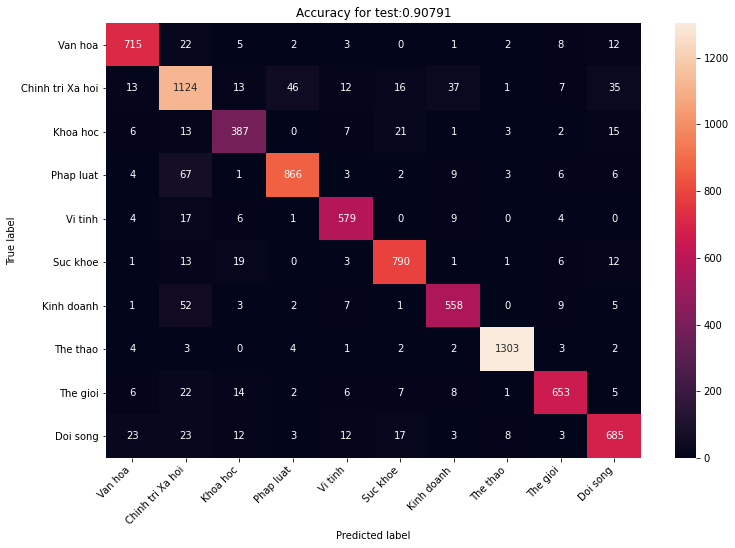

In [ ]:
plot(final_true_val,final_preds_val,'bilstm_val.png')

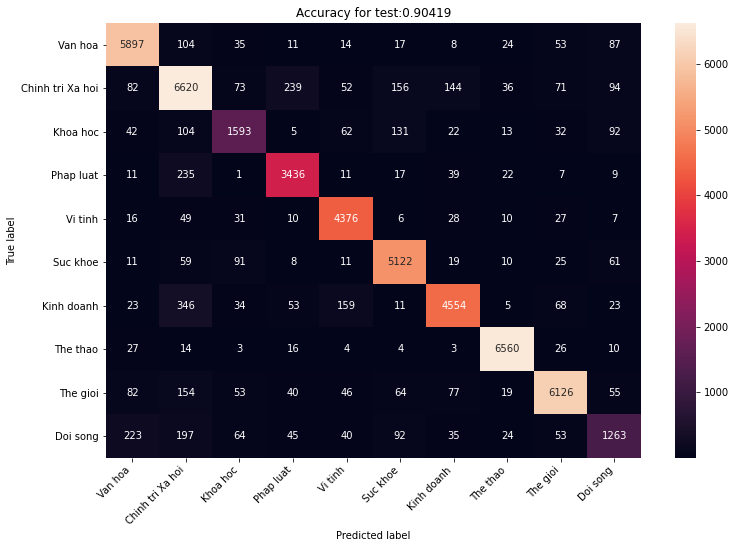

In [ ]:
plot(final_true_test,final_preds_test,'bilstm_val.png')